In [1]:
! which python

/Users/omaressaid/python_work/pipeasy-spark/.venv/bin/python


In [2]:
# Creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('titanic').getOrCreate()

In [3]:
spark

### Loading data and exploratory analysis

In [4]:
# Reading data
df = spark.read.csv('./datasets/titanic.csv', header=True, inferSchema=True, sep='\t')
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [6]:
df.count()

156

In [7]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [8]:
# Counting missing values
from pyspark.sql.functions import col, sum

df.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in df.columns)).toPandas().melt()

,variable,value
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Name,0
4,Sex,0
5,Age,30
6,SibSp,0
7,Parch,0
8,Ticket,0
9,Fare,0


In [9]:
# Count of unique values
from pyspark.sql.functions import col, countDistinct

df.select(*(countDistinct(col(c)).alias(c) for c in df.columns)).toPandas().melt()

,variable,value
0,PassengerId,156
1,Survived,2
2,Pclass,3
3,Name,156
4,Sex,2
5,Age,56
6,SibSp,6
7,Parch,5
8,Ticket,145
9,Fare,93


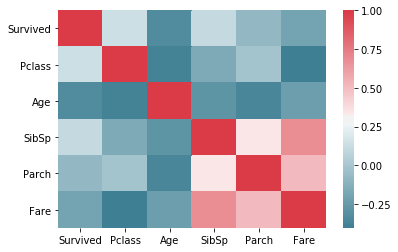

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns

num_columns = [item[0] for item in df.drop(
    'PassengerId').dtypes if not item[1] == 'string']
corr_data = VectorAssembler(inputCols=num_columns, outputCol='features').transform(
    df.dropna()).select('features')

corr_mat = Correlation.corr(corr_data, 'features').toPandas()
corr_mat = pd.DataFrame(corr_mat['pearson(features)'][0].toArray().astype(float),
                        columns=num_columns,
                        index=num_columns)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap)

### Limited example: output from dataframe-mapper (categorical & numerical transformations)

In [12]:
import pipeasy_spark as ppz
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler

df_pipe = df.drop('PassengerId', 'Name', 'Ticket', 'Cabin').dropna()
ppz_pipeline= ppz.map_by_dtypes(df_pipe,
                                target_name='Survived',
                                cat_transformers=[StringIndexer, OneHotEncoderEstimator],
                                num_transformers=[VectorAssembler, StandardScaler])
ppz_model = ppz_pipeline.fit(df_pipe)
df_pipe_out = ppz_model.transform(df_pipe)
df_pipe_out.limit(5).toPandas()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_indexed,Sex_transformed,...,Age_assembled,Age_scaled,SibSp_assembled,SibSp_scaled,Parch_assembled,Parch_scaled,Fare_assembled,Fare_scaled,label,features
0,0,3,male,22.0,1,0,7.2500,S,0.0,(1.0),...,[22.0],[1.5021431833972851],[1.0],[0.8813549847826144],[0.0],[0.0],[7.25],[0.1744835715812996],0.0,"[1.0, 1.0, 0.0, 3.723075040654779, 1.502143183..."
1,1,1,female,38.0,1,0,71.2833,C,1.0,(0.0),...,[38.0],[2.5946109531407653],[1.0],[0.8813549847826144],[0.0],[0.0],[71.2833],[1.7155537624967245],1.0,"[0.0, 0.0, 1.0, 1.241025013551593, 2.594610953..."
2,1,3,female,26.0,0,0,7.9250,S,1.0,(0.0),...,[26.0],[1.7752601258331553],[0.0],[0.0],[0.0],[0.0],[7.925],[0.1907285937630068],1.0,"(0.0, 1.0, 0.0, 3.723075040654779, 1.775260125..."
3,1,1,female,35.0,1,0,53.1000,S,1.0,(0.0),...,[35.0],[2.389773246313863],[1.0],[0.8813549847826144],[0.0],[0.0],[53.1],[1.2779417449609667],1.0,"[0.0, 1.0, 0.0, 1.241025013551593, 2.389773246..."
4,0,3,male,35.0,0,0,8.0500,S,0.0,(1.0),...,[35.0],[2.389773246313863],[0.0],[0.0],[0.0],[0.0],[8.05],[0.1937369312040637],0.0,"[1.0, 1.0, 0.0, 3.723075040654779, 2.389773246..."


### Full example: Training a random forest and defining the full pipeline (with ML)

In [13]:
df_pipe = df.drop('PassengerId', 'Name', 'Ticket', 'Cabin').dropna()
ppz_pipeline= ppz.map_by_dtypes(df_pipe,
                                target_name='Survived',
                                cat_transformers=[StringIndexer, OneHotEncoderEstimator],
                                num_transformers=[VectorAssembler, StandardScaler])

# Random split into train/test
train, test = df_pipe.randomSplit([.7,.3], seed=42)
print(train.count())
print(test.count())

99
26


In [19]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", 
                            featuresCol="features", 
                            numTrees=5, 
                            seed=42)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction",
                               outputCol="predictedLabel",
                               labels=ppz_model.stages[14].labels)

# Chain ppz_pipeline, rf and reverse label indexer
pipeline = Pipeline(stages=[ppz_pipeline, rf, labelConverter])

# Train model.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
AUROC = evaluator.evaluate(predictions)
print("Test AUROC = {0}".format(AUROC))

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|  0.0|[1.0,1.0,0.0,1.28...|
|             0|  0.0|[1.0,0.0,1.0,1.28...|
|             0|  0.0|[1.0,0.0,1.0,1.28...|
|             0|  0.0|[1.0,1.0,0.0,1.28...|
|             0|  0.0|[1.0,0.0,1.0,1.28...|
+--------------+-----+--------------------+
only showing top 5 rows

Test AUROC = 0.7523809523809525
